# <span style="color:black; font-weight:bold;">CDOEX Mouse spleen Tutorial</span>
+ <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
+ <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.10.2025
+ <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.10.2025
+ <span style="color:black; font-weight:bold;">Download</span>: CODEX Mouse spleen data used in the tutorial are available at [BALBc-1.h5ad](https://drive.google.com/open?id=1k56uujBkFX0dgtN8GfAX2rdSuXBW7GWI&usp=drive_fs) ,[BALBc-2.h5ad](https://drive.google.com/open?id=1Uh8H9yR_G8ZzFzQbxX-G28s5rdov7PaB&usp=drive_fs) and [BALBc-3.h5ad](https://drive.google.com/open?id=106MHMrFNNWp3ouAqy5A4CLIWhx3k6IGD&usp=drive_fs)
In this tutorial we apply SpaLP to 3 single sample (BALBc-1/2/3) of the CDOEX mouse spleen dataset from [Goltsev, Yury et al. Deep Profiling of Mouse Splenic Architecture with CODEX Multiplexed Imaging. Cell, Volume 174, Issue 4, 968 - 981.e15](https://www.cell.com/cell/fulltext/S0092-8674(18)30904-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418309048%3Fshowall%3Dtrue) 

The dataset have:    
+ BALBc-1: 82,251 cells with Compartment annotations and 30 proteins   
+ BALBc-2: 81,346 cells with Compartment annotations and 30 proteins  
+ BALBc-3: 80,636 cells with Compartment annotations and 30 proteins  

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">BALBc-1</span>

### <span style="color:black; font-weight:bold;">Loading BALBc-1 CODEX Mouse spleen data</span>
+ The BALBc-1 CODEX Mouse spleen data contains 82,251 cells and 30 proteins.

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-1.h5ad')
adata.var_names_make_unique()

In [5]:
adata

AnnData object with n_obs × n_vars = 82251 × 30
    obs: 'x_coordinate', 'y_coordinate', 'CellType', 'Compartment'
    obsm: 'spatial'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to perform standard data processing.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model.

In [6]:
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 50 neighbors in Xenium Breast Cancer data. k=50

In [7]:
k=50
graph = prepare_inputs(adata, k, device)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 32, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [8]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.22it/s, Epoch=199, Loss=0.8706]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed protein expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed protein expression is constructed as adata2

In [10]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding 

In [11]:
adata.obsm['SpaLP']=embedding

### Reconstructed protein expression

In [12]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

## <span style="color:black; font-weight:bold;">Identify Niches</span>
We compute KMeans clustering based on the SpaLP embeddings to identify BALBc-1 spatial niches.

In [13]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=4, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

## <span style="color:black; font-weight:bold;">The ground truth of BALBc-1</span>

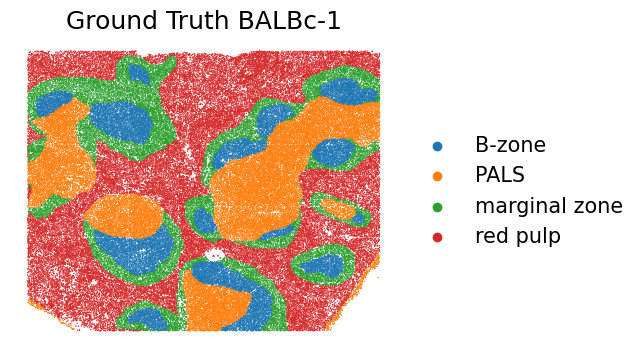

In [48]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='Compartment',ax=ax,title='Ground Truth BALBc-1',frameon=False,size=4)

## <span style="color:black; font-weight:bold;">BALBc-1 Niche identified by SpaLP</span>

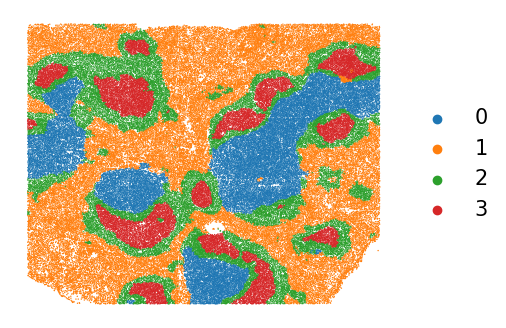

In [15]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='SpaLP',ax=ax,title='',frameon=False,size=4)

## <span style="color:black; font-weight:bold;">Calculate supervision metrics</span>
We use six supervised metrics from the [sklearn.metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics) to evaluate the performance of SpaLP, namely ARI NMI AMI FMI V-Measure Homogeneity

In [19]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['Compartment'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)

Homogeneity: 0.6150440602996743
ARI: 0.6532240560529664
NMI: 0.6173456441048983
AMI: 0.6173299721727483
FMI: 0.7489845745859496
V-Measure: 0.6173456441048983


## <span style="color:black; font-weight:bold;">BALBc-2</span>

### <span style="color:black; font-weight:bold;">Loading BALBc-2 CODEX Mouse spleen data</span>
+ The BALBc-2 CODEX Mouse spleen data contains 81,346 cells and 30 proteins.

In [51]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-2.h5ad')
adata.var_names_make_unique()

In [52]:
adata

AnnData object with n_obs × n_vars = 81346 × 30
    obs: 'x_coordinate', 'y_coordinate', 'CellType', 'Compartment'
    obsm: 'spatial'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to perform standard data processing.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model.

In [22]:
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 50 neighbors in Xenium Breast Cancer data. k=50

In [23]:
k=50
graph = prepare_inputs(adata, k, device)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 32, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [24]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.21it/s, Epoch=199, Loss=0.8303]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed protein expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed protein expression is constructed as adata2

In [26]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### cell embedding

In [27]:
adata.obsm['SpaLP']=embedding

### Reconstructed protein expression

In [28]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

## <span style="color:black; font-weight:bold;">Identify Niches</span>
We compute KMeans clustering based on the SpaLP embeddings to identify BALBc-2 spatial niches.

In [29]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=4, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

## <span style="color:black; font-weight:bold;">The ground truth of BALBc-2</span>

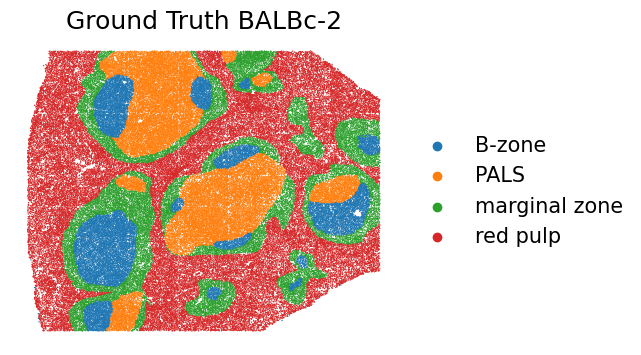

In [53]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='Compartment',ax=ax,title='Ground Truth BALBc-2',frameon=False,size=4)

## <span style="color:black; font-weight:bold;">BALBc-2 Niche identified by SpaLP</span>

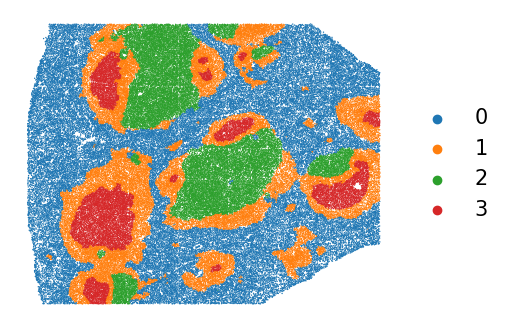

In [31]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='SpaLP',ax=ax,title='',frameon=False,size=4)

## <span style="color:black; font-weight:bold;">Calculate supervision metrics</span>
We use six supervised metrics from the [sklearn.metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics) to evaluate the performance of SpaLP, namely ARI NMI AMI FMI V-Measure Homogeneity 

In [32]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['Compartment'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)

Homogeneity: 0.6090099165306658
ARI: 0.6524095011984715
NMI: 0.6190168577647163
AMI: 0.6190006137898659
FMI: 0.7554649124215437
V-Measure: 0.6190168577647162


## <span style="color:black; font-weight:bold;">BALBc-3</span>

### <span style="color:black; font-weight:bold;">Loading BALBc-3 CODEX Mouse spleen data</span>
+ The BALBc-3 CODEX Mouse spleen data contains 80,636 cells and 30 proteins.

In [54]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/CODEX/BALBc-3.h5ad')
adata.var_names_make_unique()

In [34]:
adata

AnnData object with n_obs × n_vars = 80636 × 30
    obs: 'x_coordinate', 'y_coordinate', 'CellType', 'Compartment'
    obsm: 'spatial'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to perform standard data processing.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model.

In [35]:
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 50 neighbors in Xenium Breast Cancer data. k=50

In [36]:
k=50
graph = prepare_inputs(adata, k, device)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 32, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [37]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.39it/s, Epoch=199, Loss=0.8294]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed protein expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed protein expression is constructed as adata2

In [39]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding 

In [40]:
adata.obsm['SpaLP']=embedding

### Reconstructed protein expression

In [41]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

## <span style="color:black; font-weight:bold;">Identify Niches</span>
We compute KMeans clustering based on the SpaLP embeddings to identify BALBc-3 spatial niches.

In [42]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=4, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

## <span style="color:black; font-weight:bold;">The ground truth of BALBc-3</span>

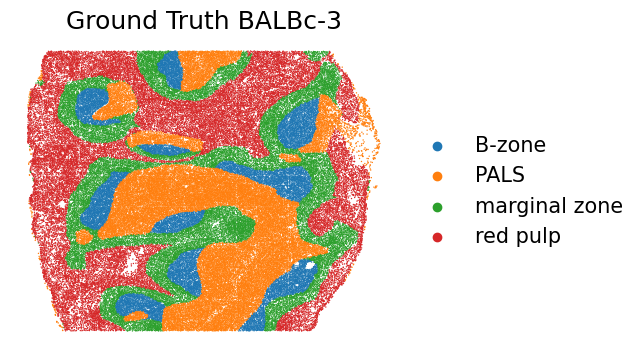

In [55]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='Compartment',ax=ax,title='Ground Truth BALBc-3',frameon=False,size=4)

## <span style="color:black; font-weight:bold;">BALBc-3 Niche identified by SpaLP</span>

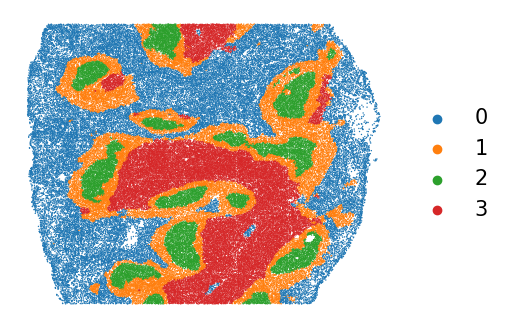

In [44]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='SpaLP',ax=ax,title='',frameon=False,size=4)

## <span style="color:black; font-weight:bold;">Calculate supervision metrics</span>
We use six supervised metrics from the [sklearn.metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics) to evaluate the performance of SpaLP, namely ARI NMI AMI FMI V-Measure Homogeneity

In [45]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['Compartment'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)

Homogeneity: 0.5553592461142408
ARI: 0.5600559721427778
NMI: 0.5576807994885141
AMI: 0.5576625417519396
FMI: 0.6773034384009827
V-Measure: 0.5576807994885142
